In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from edgedroid.models.timings import *
import edgedroid.data as default_data

exec_time_data, neuroticism_data, imp_data, dur_data = default_data.load_default_exec_time_data()
exec_time_data

,run_id,ttf,exec_time,neuroticism
0,134146,0.597441,3.654797,0.375
1,134146,0.553513,4.438645,0.375
2,134146,0.561716,2.943222,0.375
3,134146,0.586512,5.405761,0.375
4,134146,0.558940,5.225161,0.375
...,...,...,...,...
6755,137353,0.557074,6.439071,0.625
6756,137353,0.534339,4.680858,0.625
6757,137353,0.560288,3.467878,0.625
6758,137353,0.579000,2.325759,0.625


In [2]:
data = preprocess_data(exec_time_data, neuroticism_data, imp_data, dur_data)
data

,run_id,ttf,next_exec_time,neuroticism,neuroticism_raw,impairment,duration,transition,duration_raw
0,134146,0.000000,3.654797,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NoTransition,1
1,134146,0.597441,4.438645,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NoTransition,2
2,134146,0.553513,2.943222,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NoTransition,3
3,134146,0.561716,5.405761,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NoTransition,4
4,134146,0.586512,5.225161,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[5.0, 10.0)",NoTransition,5
...,...,...,...,...,...,...,...,...,...
6755,137353,0.577341,6.439071,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,6
6756,137353,0.557074,4.680858,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,7
6757,137353,0.534339,3.467878,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,8
6758,137353,0.560288,2.325759,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,9


In [3]:
import itertools
from collections import deque
import pandas as pd
from typing import Tuple, Deque
from tqdm.notebook import tqdm

result_rows = deque()

for run_id in tqdm(data["run_id"].unique(), desc="Run"):
    test_data = data[data["run_id"] == run_id].copy()

    def get_test_data(*args, **kwargs) -> Tuple[pd.DataFrame, pd.arrays.IntervalArray, pd.arrays.IntervalArray, pd.arrays.IntervalArray]:
        etime_data = exec_time_data[exec_time_data["run_id"] != run_id].copy()
        return etime_data, neuroticism_data, imp_data, dur_data

    class EmpiricalTestModel(EmpiricalETM):
        get_data = get_test_data
        
    class TheoreticalTestModel(FittedETM):
        get_data = get_test_data

    class NaiveTestModel(FirstOrderETM):
        get_data = get_test_data

    neuroticism = test_data["neuroticism_raw"].unique()[0]
    naive_model = NaiveTestModel()
    
    models: Deque[Tuple[str, ExecutionTimeModel, int, CleanupMode]] = deque()
    models.append(
        ("1st order", naive_model, 0, CleanupMode.NONE)
    )
    
    for (ttf_bins, cleanup) in itertools.product(range(1, 10), CleanupMode):
        kernel = ExponentialTTFWindowKernel(window_size=12)
        emp_model = EmpiricalTestModel(kernel=kernel, neuroticism=neuroticism, ttf_levels=ttf_bins, cleanup=cleanup)
        theo_model = TheoreticalTestModel(kernel=kernel, neuroticism=neuroticism, ttf_levels=ttf_bins, cleanup=cleanup)
        
        models.extend((
            ("empirical", emp_model, ttf_bins, cleanup),
            ("theoretical", theo_model, ttf_bins, cleanup)
        ))
        
    for _ in range(30):
        for i, (prev_ttf, exec_time) in enumerate(test_data[["ttf", "next_exec_time"]].itertuples(index=False)):
            for model_name, model, ttf_bins, cleanup in models:
                if i == 0:
                    # reset the model between runs
                    model.reset()
                else:
                    # first row has no previous ttf
                    model.advance(prev_ttf)
                    
                prediction = model.get_execution_time()
                result_rows.append({
                    "real": exec_time,
                    "prediction": prediction,
                    "error": prediction - exec_time,
                    "model": model_name,
                    "ttf_bins": ttf_bins,
                    "cleanup": str(cleanup)
                })

results = pd.DataFrame(result_rows)
results

Run:   0%|          | 0/40 [00:00<?, ?it/s]

,real,prediction,error,model,ttf_bins,cleanup
0,3.654797,7.607419,3.952622,1st order,0,CleanupMode.NONE
1,3.654797,5.041424,1.386627,empirical,1,CleanupMode.NONE
2,3.654797,8.561366,4.906569,theoretical,1,CleanupMode.NONE
3,3.654797,4.544413,0.889616,empirical,1,CleanupMode.WINSORIZE
4,3.654797,5.489641,1.834843,theoretical,1,CleanupMode.WINSORIZE
...,...,...,...,...,...,...
11153995,4.615283,12.586677,7.971393,theoretical,9,CleanupMode.NONE
11153996,4.615283,4.224631,-0.390653,empirical,9,CleanupMode.WINSORIZE
11153997,4.615283,4.986330,0.371046,theoretical,9,CleanupMode.WINSORIZE
11153998,4.615283,6.811378,2.196094,empirical,9,CleanupMode.TRUNCATE


In [4]:
import numpy as np
results["sqr_error"] = np.square(results["error"])

results

,real,prediction,error,model,ttf_bins,cleanup,sqr_error
0,3.654797,7.607419,3.952622,1st order,0,CleanupMode.NONE,15.623220
1,3.654797,5.041424,1.386627,empirical,1,CleanupMode.NONE,1.922733
2,3.654797,8.561366,4.906569,theoretical,1,CleanupMode.NONE,24.074424
3,3.654797,4.544413,0.889616,empirical,1,CleanupMode.WINSORIZE,0.791417
4,3.654797,5.489641,1.834843,theoretical,1,CleanupMode.WINSORIZE,3.366650
...,...,...,...,...,...,...,...
11153995,4.615283,12.586677,7.971393,theoretical,9,CleanupMode.NONE,63.543110
11153996,4.615283,4.224631,-0.390653,empirical,9,CleanupMode.WINSORIZE,0.152610
11153997,4.615283,4.986330,0.371046,theoretical,9,CleanupMode.WINSORIZE,0.137675
11153998,4.615283,6.811378,2.196094,empirical,9,CleanupMode.TRUNCATE,4.822831


In [5]:
results["model_tag"] = results["model"] + " " + results["cleanup"].astype(str)
results

,real,prediction,error,model,ttf_bins,cleanup,sqr_error,model_tag
0,3.654797,7.607419,3.952622,1st order,0,CleanupMode.NONE,15.623220,1st order CleanupMode.NONE
1,3.654797,5.041424,1.386627,empirical,1,CleanupMode.NONE,1.922733,empirical CleanupMode.NONE
2,3.654797,8.561366,4.906569,theoretical,1,CleanupMode.NONE,24.074424,theoretical CleanupMode.NONE
3,3.654797,4.544413,0.889616,empirical,1,CleanupMode.WINSORIZE,0.791417,empirical CleanupMode.WINSORIZE
4,3.654797,5.489641,1.834843,theoretical,1,CleanupMode.WINSORIZE,3.366650,theoretical CleanupMode.WINSORIZE
...,...,...,...,...,...,...,...,...
11153995,4.615283,12.586677,7.971393,theoretical,9,CleanupMode.NONE,63.543110,theoretical CleanupMode.NONE
11153996,4.615283,4.224631,-0.390653,empirical,9,CleanupMode.WINSORIZE,0.152610,empirical CleanupMode.WINSORIZE
11153997,4.615283,4.986330,0.371046,theoretical,9,CleanupMode.WINSORIZE,0.137675,theoretical CleanupMode.WINSORIZE
11153998,4.615283,6.811378,2.196094,empirical,9,CleanupMode.TRUNCATE,4.822831,empirical CleanupMode.TRUNCATE


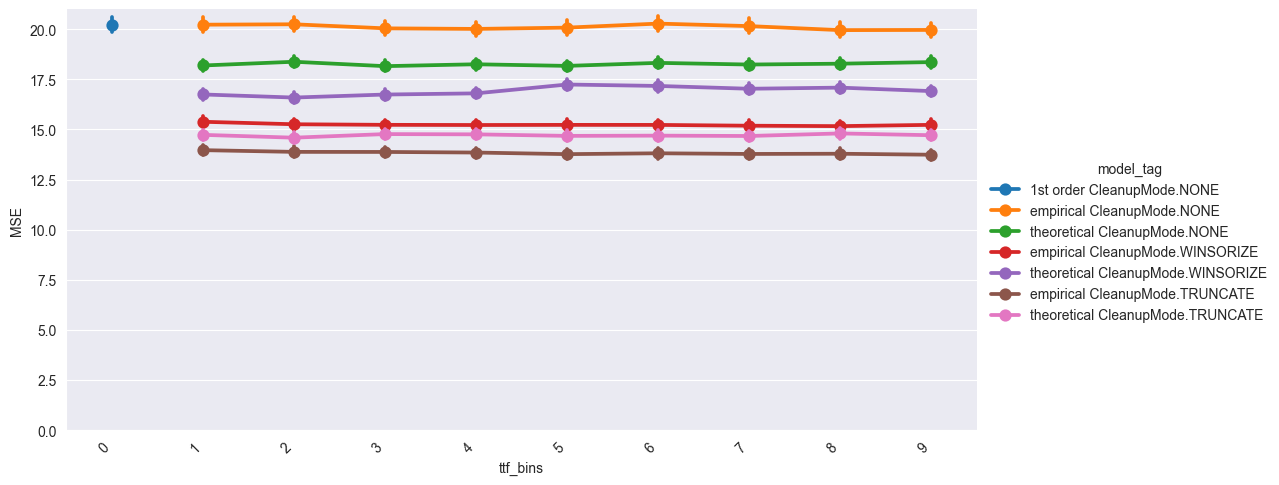

In [6]:
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fg = sns.catplot(results, kind="point", x="ttf_bins", y="sqr_error", hue="model_tag", height=5, aspect=2)
fg.set(ylim=(0, None))
fg.set_ylabels("MSE")
for ax in fg.axes.flat:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

In [7]:
results.groupby(["model", "ttf_bins", "cleanup"])["sqr_error"].mean().sort_values()

model        ttf_bins  cleanup              
empirical    9         CleanupMode.TRUNCATE     13.738465
             5         CleanupMode.TRUNCATE     13.767081
             7         CleanupMode.TRUNCATE     13.776746
             8         CleanupMode.TRUNCATE     13.787248
             6         CleanupMode.TRUNCATE     13.810169
             4         CleanupMode.TRUNCATE     13.847082
             3         CleanupMode.TRUNCATE     13.876648
             2         CleanupMode.TRUNCATE     13.880130
             1         CleanupMode.TRUNCATE     13.966195
theoretical  2         CleanupMode.TRUNCATE     14.588155
             7         CleanupMode.TRUNCATE     14.672536
             5         CleanupMode.TRUNCATE     14.678136
             6         CleanupMode.TRUNCATE     14.690138
             9         CleanupMode.TRUNCATE     14.711312
             1         CleanupMode.TRUNCATE     14.728975
             4         CleanupMode.TRUNCATE     14.754706
             3         Clea